# Perform read smoothing then assemble with LJA

In [1]:
%run "Header.ipynb"
%run "../main-workflow/utils.py"

In [2]:
import os
import time
import pickle
import pysam
import skbio
from collections import defaultdict, Counter
from linked_mutations_utils import find_mutated_positions

## 0. Quick sanity check: ensure that all $k$-mers ($k$ = 5,001) are unique in each MAG

In [3]:
# I know there are actual k-mer counting tools you can use but no reason to overcomplicate things for now

k = 5001

for seq in SEQS:
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    bargain_bin_kmer_counter = Counter()
    
    # The skbio.DNA object is 0-indexed, so 0 is the leftmost k-mer start position and
    # ((seq length) - k) is the rightmost k-mer start position. The + 1 is because python ranges don't include
    # the right endpoint.
    for start_pos in range(0, seq2len[seq] - k + 1):
        
        # NOTE: this is a terrible no good very bad way to do this; it's more efficient to use a "sliding window"
        # approach where you store the entire k-mer and then, with each step, just remove the first character and
        # add on a new last character. "But, uh, this code will only be run on these three MAGs, so I'm gonna
        # prioritize clarity over optimization," says me, the insane person who just spent like a minute writing
        # this comment when I could've been optimizing this code instead look WHATEVER this counts k-mers and it's
        # 4am let's not overcomplicate it, look if you're on GitHub right now and you see this inane comment
        # we can both just pretend that you were looking at some really optimized code and we'll both walk away
        # satisfied, capisce
        kmer = fasta[start_pos : start_pos + k]
        
        bargain_bin_kmer_counter[str(kmer)] += 1
        if start_pos % 1000000 == 0: print(f"On start pos {start_pos:,} in {seq2name[seq]}.")
    
    mckc = bargain_bin_kmer_counter.most_common(1)[0][1]
    print(f"The most common k = {k:,}-mer in {seq2name[seq]} occurred {mckc:,} time(s).")

On start pos 0 in CAMP.
On start pos 1,000,000 in CAMP.
The most common k = 5,001-mer in CAMP occurred 1 time(s).
On start pos 0 in BACT1.
On start pos 1,000,000 in BACT1.
On start pos 2,000,000 in BACT1.
The most common k = 5,001-mer in BACT1 occurred 1 time(s).
On start pos 0 in BACT2.
On start pos 1,000,000 in BACT2.
On start pos 2,000,000 in BACT2.
The most common k = 5,001-mer in BACT2 occurred 1 time(s).


## 1. Smooth reads

Lots of this code is duplicated from the `Phasing-01-MakeGraph.ipynb` notebook in this folder.

In [4]:
# Set this to True to actually generate ordinary smoothed reads that include called mutations;
# set this to False to generate "sanity check" perfect smoothed reads, where no mutations are included
# and the read entirely matches the reference
actually_include_mutations_in_the_smoothed_reads = True

# TODO change, this is just for the g1217 test
add_virtual_reads = False

In [5]:
# We'll need to know the mean coverage of each sequence when computing virtual reads.
seq2meancov = get_meancovs()
seq2meancov

Sequence edge_6104 has average coverage 4,158.57 and median coverage 4,122.00.
Sequence edge_1671 has average coverage 1,415.07 and median coverage 1,436.00.
Sequence edge_2358 has average coverage 2,993.46 and median coverage 2,936.00.


{'edge_6104': 4158.572468826692,
 'edge_1671': 1415.072755380576,
 'edge_2358': 2993.461913625056}

In [10]:
mutpos2pileup

{766856: [[1, 516, 0, 3311], 3, 5],
 1209000: [[3757, 1, 709, 3], 0, 0],
 1209009: [[3744, 703, 0, 0], 0, 26],
 1209021: [[3758, 0, 711, 1], 0, 0],
 1209057: [[0, 3773, 0, 718], 1, 0],
 1209103: [[1, 3777, 0, 713], 1, 4],
 1209114: [[706, 3773, 0, 1], 1, 10],
 1209120: [[713, 1, 3778, 0], 2, 2],
 1209125: [[3777, 1, 712, 1], 0, 3],
 1209132: [[710, 0, 3775, 2], 2, 6],
 1209135: [[1, 717, 1, 3772], 3, 1],
 1209141: [[717, 0, 3777, 0], 2, 0],
 1209144: [[1, 3776, 0, 715], 1, 1],
 1209147: [[3778, 0, 0, 714], 0, 4],
 1209153: [[714, 1, 1, 3778], 3, 3],
 1209204: [[717, 0, 3779, 0], 2, 13],
 1209240: [[725, 0, 3789, 1], 2, 8],
 1209264: [[1, 720, 3, 3791], 3, 2],
 1209265: [[0, 3796, 719, 2], 1, 0],
 1209296: [[1, 723, 0, 3790], 3, 3],
 1209321: [[2, 3784, 0, 726], 1, 0],
 1209324: [[1, 3780, 1, 725], 1, 2],
 1209336: [[0, 725, 0, 3784], 3, 1],
 1209399: [[2, 722, 1, 3783], 3, 1],
 1209402: [[3783, 0, 719, 2], 0, 3],
 1209417: [[3787, 0, 719, 0], 0, 1],
 1209420: [[1, 3784, 3, 716], 1, 3],

In [29]:
read2mp2nt = defaultdict(dict)

In [30]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")
output_dir = "phasing-data/smoothed-reads/"

# verbose?
no_indoor_voice = False

def write_out_reads(filepath, readname2seq):
    # Notably, this uses the "a" (append) method in order to add to the end of a file
    with open(filepath, "a") as of:
        for readname in readname2seq:
            # Write out both the header and the sequence for each read
            of.write(f">{readname}\n{str(readname2seq[readname])}\n")
            
# both 0-indexed and inclusive
g1217_region = [1208926, 1210074]
focus_region = [g1217_region[0] - 25000, g1217_region[1] + 25000]
            
ALN_UPDATE_FREQ = 5000
ALN_BUFFER_FREQ = 1000
VR_EXTRA_SPAN = 100

P = 10
            
t1 = time.time()
for seq in [SEQS[0]]:
    
    # Record which positions (0-indexed) aren't covered by any smoothed reads in this MAG.
    # We'll add "virtual reads" that span these positions.
    uncovered_positions = set(range(0, seq2len[seq]))
    
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    
    output_smoothed_reads_file = os.path.join(output_dir, f"{seq}_smoothed_reads_g1217_again_2.fasta")
    
    # Identify all (0-indexed, so compatible with skbio / pysam!)
    # mutated positions in this genome up front to save time.
    #
    # Equivalently, we could also just take in an arbitrary VCF as input
    # (e.g. one produced from another variant calling tool), although we'd
    # need to be careful to only include SNVs and not indels/etc...
    
    print("=" * 70)
    print(f"Identifying mutated positions (p = {P}%) in genome {seq2name[seq]}...")
    mutpos2pileup = find_mutated_positions(seq, p_to_use=P, incl_pileup=True)
    # We sort because the code below relies on these being in ascending order
    mutated_positions = sorted(mutpos2pileup.keys())
    print(f"Found {len(mutated_positions):,} mutated positions (p = {P}%) in {seq2name[seq]}.")
    print(
        f"Note that this tally is higher than you'd see in e.g. the CP1/2/3 plots, because now we're including "
        "both 'rare' and non-rare mutations. Just so you don't waste five minutes sanity-checking this like I did."
    )
    
    print("Going through these positions...")
    
    # Instead of just writing out every smoothed alignment as soon as we generate it, we build up a "buffer"
    # of these alignments and then write a bunch out at once. This way we limit slowdown due to constantly
    # having to open/close files. I don't really have a good source for this as best practice, but I remembered
    # to do it while writing this code, so somewhere in College Park the CS faculty at Maryland are smiling
    #
    # Also fyi this maps read name to smoothed alignment (well, at this point, just read) sequence. The read name
    # is useful to preserve in fasta files so we have some idea of provenance (where smoothed reads came from)
    smoothed_aln_buffer = {}
    
    # The first time we see an alignment of a read, it's 1; if we see a supp aln of this read, it's 2; etc.
    # Lets us distinguish alignments with different names
    readname2freq_so_far = defaultdict(int)
    
    # Go through all linear alignments of each read to this genome, focusing (for now) on just the primary
    # alignments...
    ts1 = time.time()
    for ai, aln in enumerate(bf.fetch(seq), 1):
        
        if ai % ALN_UPDATE_FREQ == 0:
            print(
                f"\tOn aln {ai:,} in seq {seq2name[seq]}. "
                f"Time spent on {seq2name[seq]} so far: {time.time() - ts1:,.2f} sec."
            )
            
        if aln.is_secondary:
            raise ValueError(
                "Not to get political or anything, but you should've already filtered secondary alns out"
            )
            
        # Note that supplementary alignments are ok, though! We implicitly handle these here.
        #
        # Different alignments of the same read will have different new_readnames, because we're gonna
        # be treating them as distinct "reads". We should have already filtered reference-overlapping
        # supp alns so this shouldn't be a problem
        
        readname = aln.query_name
        readname2freq_so_far[readname] += 1
        new_readname = f"{readname}_{readname2freq_so_far[readname]}"
        
        # should never happen
        if new_readname in smoothed_aln_buffer:
            raise ValueError("This exact read alignment has already been smoothed? Weird.")
            
        # Figure out where on the MAG this alignment "hits." These are 0-indexed positions from Pysam.
        # (reference_end points to the position after the actual final position, since these are designed to
        # be interoperable with Python's half-open intervals.)
        #
        # Of course, there likely will be indels within this range: we're purposefully ignoring those here.
        ref_start = aln.reference_start
        ref_end = aln.reference_end - 1
        
        # This should never happen (TM)
        if ref_start >= ref_end:
            # Du sollst jetzt mit Gott sprechen.
            raise ValueError(
                f"Ref start {ref_start:,} >= ref end {ref_end:,} for read {new_readname}?"
            )
            
        # Figure out if this read intersects with the focus region
        # An idiot-proof albeit slow solution is just computing exact ranges and then taking set intersections
        if not set(range(ref_start, ref_end + 1)) & set(range(focus_region[0], focus_region[1] + 1)):
            continue
            
        # Record which positions this read covers (of course, it may not exactly "cover" these positions
        # originally due to indels, but the smoothed version will cover them).
        uncovered_positions -= set(range(ref_start, ref_end + 1))
        
        # Smoothed sequence; we'll edit this so that if this read has (mis)matches to any called mutated
        # positions, these positions are updated with the read's aligned nucleotides at these positions.
        smoothed_aln_seq = fasta[ref_start: ref_end + 1]
        
        if actually_include_mutations_in_the_smoothed_reads:
            # just for debugging: track the exact edits made to smoothed_aln_seq
            replacements_made = {}

            ap = aln.get_aligned_pairs(matches_only=True)

            # Iterating through the aligned pairs is expensive. Since read lengths are generally in the thousands
            # to tens of thousands of bp (which is much less than the > 1 million bp length of any bacterial genome),
            # we set things up so that we only iterate through the aligned pairs once. We maintain an integer, mpi,
            # that is a poor man's "pointer" to an index in mutated_positions.

            mpi = 0

            # Go through this aln's aligned pairs. As we see each pair, compare the pair's reference position
            # (refpos) to the mpi-th mutated position (herein referred to as "mutpos").
            #
            # If refpos >  mutpos, increment mpi until refpos <= mutpos (stopping as early as possible).
            # If refpos == mutpos, we have a match! Update readname2mutpos2ismutated[mutpos] based on
            #                      comparing the read to the reference at the aligned positions.
            # If refpos <  mutpos, continue to the next pair.

            for pair in ap:

                refpos = pair[1]
                mutpos = mutated_positions[mpi]

                no_mutations_to_right_of_here = False

                # Increment mpi until we get to the next mutated position at or after the reference pos for this
                # aligned pair (or until we run out of mutated positions).
                while refpos > mutpos:
                    mpi += 1
                    if mpi < len(mutated_positions):
                        mutpos = mutated_positions[mpi]
                    else:
                        no_mutations_to_right_of_here = True
                        break

                # I expect this should happen only for reads aligned near the right end of the genome.
                if no_mutations_to_right_of_here:
                    break

                # If the next mutation occurs after this aligned pair, continue on to a later pair.
                if refpos < mutpos:
                    continue

                # If we've made it here, refpos == mutpos!
                # (...unless I messed something up in how I designed this code.)
                if refpos != mutpos:
                    raise ValueError("This should never happen!")

                # Finally, get the nucleotide aligned to this mutated position from this read.
                readpos = pair[0]
                read_nt = aln.query_sequence[readpos]

                # If this read doesn't have match the first or second most common nucleotide at this position,
                # "smooth" it to just have the most common nucleotide. In the future, when we perform read
                # smoothing based on an arbitrary set of SNV calls, we can be more careful about this; but for now
                # we make the simplifiying assumption that a mutation likely only has one alternate nucleotide,
                # and that the 3rd and 4th most common nucleotides indicate errors.
                # (Also, note that we break ties here arbitrarily.)
                nt2ct = dict(zip("ACGT", mutpos2pileup[mutpos][0]))
                nt1 = max(nt2ct, key=nt2ct.get)
                del nt2ct[nt1]
                nt2 = max(nt2ct, key=nt2ct.get)
                
                if read_nt != nt1 and read_nt != nt2:
                    if no_indoor_voice:
                        print(
                            f"Read {new_readname} has 3rd or 4th most common nt at mutpos {mutpos + 1:,}: "
                            f"pileup = {mutpos2pileup[mutpos]}, read = {read_nt}"
                        )
                    read_nt = nt1
                    
                # Notably, the nucleotide at a mutated position in a smoothed read will always be the first
                # or second most common nucleotide at this position. So "unreasonable" positions, in which
                # the ref nt != the consensus nt, will not be treated as you might expect -- we ignore the
                # reference in this particular case. Shouldn't make a big difference, since in most cases
                # the ref and consensus nt agree.
                relative_pos_on_aln = mutpos - ref_start
                smoothed_aln_seq = smoothed_aln_seq.replace([relative_pos_on_aln], read_nt)
                replacements_made[relative_pos_on_aln] = read_nt
                read2mp2nt[new_readname][mutpos] = read_nt
                if no_indoor_voice:
                    print(
                        f"Read {new_readname} mismatches ref at mutpos {mutpos + 1:,}: "
                        f"ref = {ref_nt}, read = {read_nt}"
                    )

            if no_indoor_voice:
                print(f"Read {new_readname} required {len(replacements_made):,} replacements!")
        
        # Now that we've finished processing all called mutations that this alignment spans, prepare it
        # to be written out to a FASTA file. See comments above on smoothed_aln_buffer, and why we don't
        # just write everything out as soon as it's ready.
        #
        # (Also, we've already guaranteed readname isn't already in smoothed_aln_buffer, so no need to worry
        # about accidentally overwriting something from earlier.)
        smoothed_aln_buffer[new_readname] = smoothed_aln_seq
        
        if ai % ALN_BUFFER_FREQ == 0:
            write_out_reads(output_smoothed_reads_file, smoothed_aln_buffer)
            # Clear the buffer
            smoothed_aln_buffer = {}
        
    # We're probably going to have left over smoothed reads that we still haven't written out, unless things
    # worked out so that on the final alignment we saw ai was exactly divisible by ALN_BUFFER_FREQ (and that's
    # pretty unlikely unless you set the buffer freq to a low number). So make one last dump of the buffer.
    if len(smoothed_aln_buffer) > 0:
        write_out_reads(output_smoothed_reads_file, smoothed_aln_buffer)
        
    if add_virtual_reads and len(uncovered_positions) > 0:
        print(f"For reference, there are {len(uncovered_positions):,} uncovered positions in {seq2name[seq]}.")
        
        sup = sorted(uncovered_positions)
        uc_runs = convert_to_runs(sup)
        print(f'And there are {len(uc_runs)} "runs" of uncovered positions.')
        
        rounded_meancov = round(seq2meancov[seq])
        print(
            f'Adding "virtual reads" spanning each of these runs, at rounded mean coverage '
            f'of {rounded_meancov:,}x, to account for this...'
        )
        
        num_vr = 0
        vr_buffer = {}
        for run in uc_runs:
            # Construct a virtual read that includes this entire run of uncovered positions as well
            # as VR_EXTRA_SPAN positions before and after (clamping to the start/end of the seq if needed).
            #
            # Notably, we could try to make this loop around from end -> start if this is a cyclic MAG, but
            # to remain consistent with how we handle supplementary alignments above -- and because implementing
            # the loop around would be a lot of work and it's like 3am -- we ignore this for now.
            #
            # Also, note that run_start can equal run_end, if only a single isolated position is uncovered.
            # This is fine -- the code handles this case automatically. (I guess the only potential problem is
            # if the length of the MAG is less than VR_EXTRA_SPAN, but... that should never happen. If you have
            # like 100bp-long MAGs that's a problem! I guess, TODO, make note of this when generalizing this
            # code.)
            
            run_start = max(run[0] - VR_EXTRA_SPAN, 0)
            run_end = min(run[1] + VR_EXTRA_SPAN, seq2len[seq] - 1)
            
            # Generate a sequence matching the "reference" MAG at these positions. We of course don't have
            # any info about mutations here, because these positions are uncovered by the real reads!
            vr_seq = fasta[run_start: run_end + 1]
            
            # We need to assign reads unique names, and including the run coordinates here is a nice way
            # to preserve uniqueness across runs and also make our smoothed reads files easier to interpret
            vr_name_prefix = f"vr_{run[0]}_{run[1]}"
            
            # Add M copies of this virtual read, where M = (rounded mean coverage of this MAG)
            for vr_num in range(1, rounded_meancov + 1):
                vr_name = f"{vr_name_prefix}_{vr_num}"
                vr_buffer[vr_name] = vr_seq
                num_vr += 1
                
        write_out_reads(output_smoothed_reads_file, vr_buffer)
        print(f"Wrote out {num_vr:,} virtual reads.")
    
    print(f"Done with {seq}! Took {time.time() - ts1:,.2f} sec.")
        
print(f"Time taken: {time.time() - t1:,} sec.")

Identifying mutated positions (p = 10%) in genome CAMP...
Found 35 mutated positions (p = 10%) in CAMP.
Note that this tally is higher than you'd see in e.g. the CP1/2/3 plots, because now we're including both 'rare' and non-rare mutations. Just so you don't waste five minutes sanity-checking this like I did.
Going through these positions...
	On aln 5,000 in seq CAMP. Time spent on CAMP so far: 6.07 sec.
	On aln 10,000 in seq CAMP. Time spent on CAMP so far: 13.10 sec.
	On aln 15,000 in seq CAMP. Time spent on CAMP so far: 20.20 sec.
	On aln 20,000 in seq CAMP. Time spent on CAMP so far: 27.59 sec.
	On aln 25,000 in seq CAMP. Time spent on CAMP so far: 34.47 sec.
	On aln 30,000 in seq CAMP. Time spent on CAMP so far: 41.04 sec.
	On aln 35,000 in seq CAMP. Time spent on CAMP so far: 47.38 sec.
	On aln 40,000 in seq CAMP. Time spent on CAMP so far: 53.74 sec.
	On aln 45,000 in seq CAMP. Time spent on CAMP so far: 60.05 sec.
	On aln 50,000 in seq CAMP. Time spent on CAMP so far: 66.25 sec

In [31]:
with open("read2mp2nt.pickle", "wb") as pf:
    pickle.dump(read2mp2nt, pf)

In [23]:
with open("read2mp2nt.pickle", "rb") as pf:
    read2mp2nt = pickle.load(pf)

In [24]:
mp2freq = defaultdict(Counter)
for read in read2mp2nt:
    for mp in read2mp2nt[read]:
        mp2freq[mp][read2mp2nt[read][mp]] += 1      

In [25]:
mp2freq

defaultdict(collections.Counter,
            {1209000: Counter({'A': 3761, 'G': 709}),
             1209009: Counter({'A': 3744, 'C': 703}),
             1209021: Counter({'A': 3759, 'G': 711}),
             1209057: Counter({'C': 3773, 'T': 718}),
             1209103: Counter({'C': 3778, 'T': 713}),
             1209114: Counter({'C': 3774, 'A': 706}),
             1209120: Counter({'G': 3779, 'A': 713}),
             1209125: Counter({'A': 3779, 'G': 712}),
             1209132: Counter({'G': 3777, 'A': 710}),
             1209135: Counter({'T': 3774, 'C': 717}),
             1209141: Counter({'G': 3777, 'A': 717}),
             1209144: Counter({'C': 3777, 'T': 715}),
             1209147: Counter({'A': 3778, 'T': 714}),
             1209153: Counter({'T': 3780, 'A': 714}),
             1209204: Counter({'G': 3779, 'A': 717}),
             1209240: Counter({'G': 3790, 'A': 725}),
             1209264: Counter({'T': 3795, 'C': 720}),
             1209265: Counter({'C': 3798, 'G': 71

In [27]:
haps = []
mps = [1209000, 1209009, 1209021, 1209057, 1209103, 1209114, 1209120, 1209125,
       1209132, 1209135, 1209141, 1209144, 1209147, 1209153, 1209204, 1209240,
       1209264, 1209265, 1209296, 1209321, 1209324, 1209336, 1209399, 1209402,
       1209417, 1209420, 1209423, 1209522, 1209576, 1209609, 1209696, 1209699,
       1209756, 1209795]
assert len(mps) == 34
for read in read2mp2nt:
    # if this read spans all of g1217
    if len(read2mp2nt[read]) == 34:
        haps.append("".join([read2mp2nt[read][mp] for mp in mps]))

In [28]:
print("\n".join(haps))

AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA
ACGTTAAGACATTAAACGCTTCCGGTCGGTACGG
AAACCCGAGTGCATGGTCTC

In [29]:
len(haps)

4086

In [30]:
ctr = Counter(haps)
ctr

Counter({'AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA': 3445,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG': 600,
         'ACGTTAAGACATTAAACGCTTCCGGTCGGTACGG': 4,
         'GAGCTAAGACATTAAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGATCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGCCGGTACGG': 1,
         'GAGTTAAGACATTAAACGCTTCCGGTCGGTACGG': 6,
         'GCGTTAAGACATTTAACGCTTCCGGTCGGTACGG': 2,
         'GCGTTAAGACACTAAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCAGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGCACAG': 1,
         'GCGTTAAGACATTAAACGCTTCCAGCCGGTACGG': 1,
         'GCGTTAAAACATTAAACGCTTCCAGTCGGTACGG': 1,
         'GCATTAAGACATTAAACGCTTCCGGTCGGTACGG': 2,
         'GCGTTAGGACATTAAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCTGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGTACAG': 4,
         'GCGTTAAGACATTAAACGCTTCCGGTCGATACGG': 1,
         'GCGTTAAGACATTAGACGCTTCCGGTCGGTACAG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGCACGG'

In [58]:
len(ctr)

28

In [33]:
ref = ctr.most_common(1)[0][0]
assert len(ref) == 34
assert ctr[ref] == 3445
ref

'AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA'

In [34]:
alt = "GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG"
assert ctr[alt] == 600

In [35]:
haplotype_hamrefs = []
haplotype_diffpos = []
for h in ctr:
    rd = []
    ad = []
    for hi, hc in enumerate(h):
        if hc != ref[hi]:
            rd.append(hi + 1)
        if hc != alt[hi]:
            ad.append(hi + 1)
    print(f"{h}: {ctr[h]:,}x, Hamming ref = {len(rd):,}, Hamming alt = {len(ad):,},", end=" ")
    if len(rd) < len(ad):
        print(f"Ref diffs: {rd}")
        haplotype_diffpos += rd
    else:
        print(f"Alt diffs: {ad}")
        haplotype_diffpos += ad
        
    haplotype_hamrefs.append(len(rd))

AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA: 3,445x, Hamming ref = 0, Hamming alt = 34, Ref diffs: []
GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG: 600x, Hamming ref = 34, Hamming alt = 0, Alt diffs: []
ACGTTAAGACATTAAACGCTTCCGGTCGGTACGG: 4x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [1]
GAGCTAAGACATTAAACGCTTCCGGTCGGTACGG: 1x, Hamming ref = 32, Hamming alt = 2, Alt diffs: [2, 4]
GCGTTAAGACATTAAACGCTTCCGATCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [25]
GCGTTAAGACATTAAACGCTTCCGGCCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [26]
GAGTTAAGACATTAAACGCTTCCGGTCGGTACGG: 6x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [2]
GCGTTAAGACATTTAACGCTTCCGGTCGGTACGG: 2x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [14]
GCGTTAAGACACTAAACGCTTCCGGTCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [12]
GCGTTAAGACATTAAACGCTTCCAGTCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [24]
GCGTTAAGACATTAAACGCTTCCGGTCGGCACAG: 1x, Hamming ref = 32, Hamming alt = 2, Alt diffs: [3

Text(0.5, 1.0, 'Positional variation across\nthe 26 non-primary haplotypes')

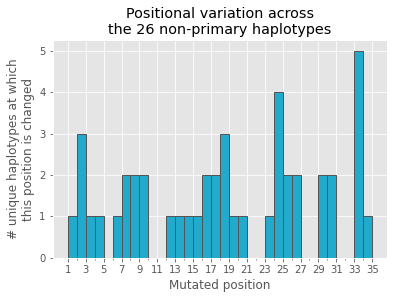

In [151]:
fig, ax = pyplot.subplots()
ax.hist(haplotype_diffpos, bins=range(1,36,1), color="#22aacc", lw=1, edgecolor="#555555")
ax.set_xticks(range(1, 36, 2))
ax.set_xticks(range(1, 36), minor=True)
ax.set_xlabel("Mutated position")
ax.set_ylabel("# unique haplotypes at which\nthis position is changed")
ax.set_title("Positional variation across\nthe 26 non-primary haplotypes")

Text(0.5, 1.0, 'Histogram of haplotype coverages in CAMP gene 1217,\nignoring the primary haplotypes (3,445x and 600x)')

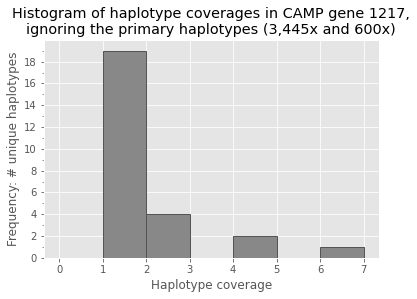

In [41]:
haplotype_covs = [ctr[h] for h in ctr]
fig, ax = pyplot.subplots()
ax.hist(haplotype_covs, bins=range(0,8,1), color="#888888", lw=1, edgecolor="#555555")
ax.set_yticks(range(0, 20, 2))
ax.set_yticks(range(1, 20, 1), minor=True)
ax.set_xlabel('Haplotype coverage')
ax.set_ylabel("Frequency: # unique haplotypes")
ax.set_title("Histogram of haplotype coverages in CAMP gene 1217,\nignoring the primary haplotypes (3,445x and 600x)")

Text(0.5, 1.0, 'Histogram of haplotype Hamming distances\nin CAMP gene 1217')

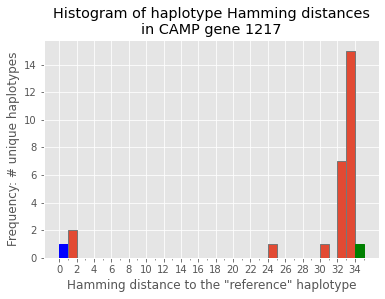

In [124]:
fig, ax = pyplot.subplots()
ax.hist(haplotype_hamrefs, bins=range(0,36,1), lw=1, edgecolor="#777777")
ax.set_xticks(range(0, 36, 2))
ax.set_xticks(range(0, 36), minor=True)
ax.set_xlabel('Hamming distance to the "reference" haplotype')
ax.set_ylabel("Frequency: # unique haplotypes")
# color bars representing the ref and alt haplotype specially:
# https://stackoverflow.com/a/18973430
children = ax.get_children()
children[0].set_color("blue")
children[-11].set_color("green")
ax.set_title("Histogram of haplotype Hamming distances\nin CAMP gene 1217")

In [55]:
# Investigate alignments of LJA (no ec) contigs to CAMP
f = pysam.AlignmentFile("phasing-data/smoothed-reads/edge_6104_g1217_lja_20220224/lja2camp.sam")
contig2hap = {}
contig_haps = []
for aln in f.fetch():
    ap = aln.get_aligned_pairs(matches_only=True)
    aln_seq = aln.query_sequence
    contig_name = aln.query_name
    v = {}
    hap = ""
    # slow but simple
    for pair in ap:
        if pair[1] in mps:
            contig_nt_at_mutpos = aln_seq[pair[0]]
            v[pair[1]] = contig_nt_at_mutpos
            hap += contig_nt_at_mutpos
    if len(v) != 34: raise ValueError("what how")
    contig2hap[contig_name] = hap
    contig_haps.append(hap)
    print(f"{hap}  Smoothed Read Freq: {ctr[hap]:,}x  Contig {contig_name}") 
    
print(f"# of contig haps: {len(contig_haps):,}\n# of unique contig haps: {len(set(contig_haps)):,}")

GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG  Smoothed Read Freq: 600x  Contig 107
GAGTTAAGACATTAAACGCTTCCGGTCGGTACGG  Smoothed Read Freq: 6x  Contig 101
GCGTTAAGACATTTAACGCTTCCGGTCGGTACGG  Smoothed Read Freq: 2x  Contig 133
GCGTTAGGACATTAAACGCTTCCGGTCGGTACGG  Smoothed Read Freq: 1x  Contig 122
GCGTTAAGACATTAAACGCTTCCAGTCGGTACGG  Smoothed Read Freq: 1x  Contig 43
GCATTAAGACATTAAACGCTTCCGGTCGGTACGG  Smoothed Read Freq: 2x  Contig 105
GCGTTAAAACATTAAACGCTTCCAGTCGGTACGG  Smoothed Read Freq: 1x  Contig 44
GCGTTAAGACATTAAACGCTTCCGGCCGGTACGG  Smoothed Read Freq: 1x  Contig 170
GCGTTCAGACATTAAACGCTTCCGGTCGGTACGG  Smoothed Read Freq: 0x  Contig 86
AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA  Smoothed Read Freq: 3,445x  Contig 60
# of contig haps: 10
# of unique contig haps: 10


In [59]:
# Investigate alignments of LJA (with ec) contig to CAMP
f = pysam.AlignmentFile("phasing-data/smoothed-reads/edge_6104_g1217_lja_20220224_withec/lja_withec2camp.sam")
for aln in f.fetch():
    ap = aln.get_aligned_pairs(matches_only=True)
    aln_seq = aln.query_sequence
    hap = ""
    for pair in ap:
        if pair[1] in mps:
            hap += aln_seq[pair[0]]
    if len(hap) != 34: raise ValueError("what how")
    print(f"{hap}  Smoothed Read Freq: {ctr[hap]:,}x") 

AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA  Smoothed Read Freq: 3,445x


In [63]:
# Investigate alignments of metaFlye contig to CAMP
f = pysam.AlignmentFile("phasing-data/smoothed-reads/edge_6104_g1217_metaflye_20220224/mfkh2camp.sam")
for aln in f.fetch():
    ap = aln.get_aligned_pairs(matches_only=True)
    aln_seq = aln.query_sequence
    hap = ""
    for pair in ap:
        if pair[1] in mps:
            hap += aln_seq[pair[0]]
    if len(hap) != 34: raise ValueError("what how")
    print(f"{hap}  Smoothed Read Freq: {ctr[hap]:,}x") 

AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA  Smoothed Read Freq: 3,445x


## 1.5. Stats about smoothed read lengths

We could have just figured this out while computing the stuff above, but ... I didn't have the foresight to think of this earlier, and I don't want to rerun that stuff for another >1 hour, so we just loop through the FASTA files we just generated quickly

In [9]:
for seq in SEQS:
    read_lengths = []
    
    # Parse a FASTA file -- I stole this code from myself in the Diversity Indices notebook
    with open(f"phasing-data/smoothed-reads/{seq}_smoothed_reads.fasta", "r") as fastafile:

        # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
        # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
        for linenum, line in enumerate(fastafile):

            if line.startswith(">"):
                if linenum % 2 != 0:
                    raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            else:
                if linenum % 2 != 1:
                    raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")

                read_lengths.append(len(line.strip()))

    num_reads = len(read_lengths)
    minlen = min(read_lengths)
    maxlen = max(read_lengths)
    avglen = mean(read_lengths)
    medlen = median(read_lengths)
    
    # Reads with length less than w + k = (threshold) will be ignored by jumboDB when constructing
    # the graph, so we output stats about this to verify that we're not dropping a TON of reads
    # (ofc ideally we wouldn't drop any tho...)
    threshold = 7001
    geq_threshold = len([rl for rl in read_lengths if rl >= threshold])
    pct = 100 * (geq_threshold / num_reads)
    
    print(f"{seq2name[seq]}: {num_reads:,} smoothed reads")
    print(f"\tmin / mean / median / max length = {minlen:,} / {avglen:,.1f} / {medlen:,} / {maxlen:,}")
    print(f"\tNum of reads with length \u2265 {threshold:,}: {geq_threshold:,} / {num_reads:,} ({pct:.1f}%)")

CAMP: 476,356 smoothed reads
	min / mean / median / max length = 200 / 11,264.7 / 11,154.0 / 35,099
	Num of reads with length ≥ 7,001: 438,334 / 476,356 (92.0%)
BACT1: 265,975 smoothed reads
	min / mean / median / max length = 202 / 11,487.2 / 11,473 / 39,723
	Num of reads with length ≥ 7,001: 243,480 / 265,975 (91.5%)
BACT2: 742,926 smoothed reads
	min / mean / median / max length = 200 / 11,318.0 / 11,259.0 / 40,346
	Num of reads with length ≥ 7,001: 673,220 / 742,926 (90.6%)


## 2. Construct de Bruijn graph(s) from these smoothed reads

Possible TODO: adjust this to detect the options above (which mutations are we using? did we actually include mutations in the smoothed reads?) and adjust where files get spit out to accordingly

### 2.1. jumboDBG

#### 2.1.1. Run jumboDBG

In [10]:
!/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/edge_6104_jumbo_20220221

!/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/edge_1671_smoothed_reads.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/edge_1671_jumbo_20220221

!/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/edge_2358_smoothed_reads.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/edge_2358_jumbo_20220221

00:00:00 14.5Gb  INFO: Hello! You are running jumboDBG, a tool for construction of de Bruijn graphs for arbitrarily large values of k
00:00:00 14.5Gb  INFO: Note that jumboDBG does not perform any error correction and ignores all reads shorter than k + w = 7001
00:00:00 0Mb  INFO: Reading reads
00:00:00 0Mb  INFO: Extracting minimizers
00:00:28 3.3Gb  INFO: Finished read processing
00:00:28 3.3Gb  INFO: 2541151 hashs collected. Starting sorting.
00:00:28 3.4Gb  INFO: Finished sorting. Total distinct minimizers: 1695
00:00:28 3.4Gb  INFO: Starting construction of sparse de Bruijn graph
00:00:28 3.4Gb  INFO: Vertex map constructed.
00:00:28 3.4Gb  INFO: Filling edge sequences.
00:00:55 4.5Gb  INFO: Finished sparse de Bruijn graph construction.
00:00:55 4.5Gb  INFO:  Collecting tips 
00:00:55 4.5Gb  INFO: Added 58 artificial minimizers from tips.
00:00:55 4.5Gb  INFO: Collected 3498 old edges.
00:00:55 4.5Gb  INFO: New minimizers added to sparse graph.
00:00:55 4.5Gb  INFO: Refilling grap

#### 2.1.2. Filter jumboDBG graphs to remove low-coverage edges

In [3]:
# yanked and slightly modified from main-workflow/utils.py
import networkx as nx

def load_gfa(filepath):
    
    # We ignore directionality for right now.
    graph = nx.Graph()

    with open(filepath, "r") as gfafile:
        for line in gfafile:
            if line[0] == "S":
                parts = line.strip().split("\t")
                node_name = parts[1]
                node_len = len(parts[2])
                node_cov = None

                # Parse GFA tags
                extra_data = parts[3:]
                for tag in extra_data:
                    # This is overcautious, probably, but whatevs
                    if tag.startswith("LN:i:"):
                        raise ValueError("Duplicate length for node {}".format(node_name))
                    elif tag.startswith("dp:i:") or tag.startswith("KC:i:"):
                        if node_cov is None:
                            node_cov = int(tag[5:])
                        else:
                            raise ValueError("Duplicate coverage for node {}".format(node_name))

                if node_cov is None:
                    raise ValueError("No coverage tag given for node {}".format(node_name))

                graph.add_node(node_name, length=node_len, cov=node_cov)

            elif line[0] == "L":
                parts = line.strip().split("\t")
                src = parts[1]
                snk = parts[3]
                src_orient = parts[2]
                snk_orient = parts[4]
                graph.add_edge(src, snk, src_orient=src_orient, snk_orient=snk_orient)
    return graph

In [37]:
MIN_EDGE_COV = 5
for seq in SEQS:
    phdir = f"phasing-data/smoothed-reads/{seq}_jumbo_20220221"
    g = load_gfa(os.path.join(phdir, "graph.gfa"))
    removed_nodes = []
    for n in list(g.nodes):
        if g.nodes[n]["cov"] < MIN_EDGE_COV:
            g.remove_node(n)
            removed_nodes.append(n)
    print(f"{seq2name[seq]}: Removed {len(removed_nodes):,} node(s) with coverage < {MIN_EDGE_COV}x.")

    # Probs possible to merge this together with the filtering step above so we only loop over the nodes once
    with open(os.path.join(phdir, "graph-covfilt.gfa"), "w") as f:
        f.write("H\tVN:Z:1.0\n")
        for n in g.nodes:
            f.write(f"S\t{n}\t*\tKC:i:{g.nodes[n]['cov']}\tLN:i:{g.nodes[n]['length']}\n")
        for e in g.edges:
            src_or = g.edges[e]["src_orient"]
            snk_or = g.edges[e]["snk_orient"]
            f.write(f"L\t{e[0]}\t{src_or}\t{e[1]}\t{snk_or}\t*\n")

CAMP: Removed 1 node(s) with coverage < 5x.
BACT1: Removed 14 node(s) with coverage < 5x.
BACT2: Removed 4 node(s) with coverage < 5x.


In [21]:
## Just inspecting the G1217 graph coverages
phdir = f"phasing-data/smoothed-reads/edge_6104_g1217_jumbo_20220224/"
g = load_gfa(os.path.join(phdir, "graph.gfa"))
print(f"{len(g.nodes):,} segments and {len(g.edges):,} links.")


with open(os.path.join(phdir, "graph-covfilt-bd.gfa"), "w") as f:
    f.write("H\tVN:Z:1.0\n")
    
    included_nodes = []
    bd_total = 0
    for n in g.nodes:
        bd = g.nodes[n]['cov'] / g.nodes[n]['length']
        if bd >= 10:
            included_nodes.append(n)
            f.write(f"S\t{n}\t*\tKC:i:{g.nodes[n]['cov']}\tLN:i:{g.nodes[n]['length']}\n")
            
        bd_total += bd
        # print(f"Seg is {g.nodes[n]['length']:,} bp long and has KC {g.nodes[n]['cov']}x; Bandage depth is {round(bd)}x")
    print(f"The total Bandage depth (cov / len) is {round(bd_total):,}x.")
        
    num_incl_edges = 0
    for e in g.edges:
        if e[0] in included_nodes and e[1] in included_nodes:
            num_incl_edges += 1
            src_or = g.edges[e]["src_orient"]
            snk_or = g.edges[e]["snk_orient"]
            f.write(f"L\t{e[0]}\t{src_or}\t{e[1]}\t{snk_or}\t*\n")
            
    print(f"Including {len(included_nodes):,} segments and {num_incl_edges:,} links.")

103 segments and 116 links.
The total Bandage depth (cov / len) is 4,836x.
Including 10 segments and 4 links.


### 2.2. LJA (including jumboDBG and multiplexDBG)

`--noec` is an undocumented flag that avoids the error correction step in LJA, which is what we want.

In [8]:
!/home/mfedarko/software/LJA/bin/lja \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads.fasta \
    --noec \
    --output-dir phasing-data/smoothed-reads/edge_6104_lja_noec

!/home/mfedarko/software/LJA/bin/lja \
    --reads phasing-data/smoothed-reads/edge_1671_smoothed_reads.fasta \
    --noec \
    --output-dir phasing-data/smoothed-reads/edge_1671_lja_noec

!/home/mfedarko/software/LJA/bin/lja \
    --reads phasing-data/smoothed-reads/edge_2358_smoothed_reads.fasta \
    --noec \
    --output-dir phasing-data/smoothed-reads/edge_2358_lja_noec

00:00:00 14.5Gb  INFO: Hello! You are running La Jolla Assembler (LJA), a tool for genome assembly from PacBio HiFi reads
00:00:00 14.5Gb  INFO: 02ec23dd81b81ce8718a70fb64ea6fab0d88c5ca
00:00:00 14.5Gb  INFO: LJA pipeline started
00:00:00 14.5Gb  INFO: Performing initial correction with k = 5001
00:00:00 0Mb  INFO: Reading reads
00:00:00 0Mb  INFO: Extracting minimizers
00:00:17 4.3Gb  INFO: Finished read processing
00:00:17 4.3Gb  INFO: 5257129 hashs collected. Starting sorting.
00:00:17 4.3Gb  INFO: Finished sorting. Total distinct minimizers: 4475
00:00:17 4.3Gb  INFO: Starting construction of sparse de Bruijn graph
00:00:17 4.3Gb  INFO: Vertex map constructed.
00:00:17 4.3Gb  INFO: Filling edge sequences.
00:00:34 4.3Gb  INFO: Finished sparse de Bruijn graph construction.
00:00:34 4.3Gb  INFO:  Collecting tips 
00:00:34 4.3Gb  INFO: Added 60 artificial minimizers from tips.
00:00:34 4.3Gb  INFO: Collected 8998 old edges.
00:00:34 4.3Gb  INFO: New minimizers added to sparse graph.
0

00:04:23 0.5Gb  INFO: Export to Dot
00:04:23 0.5Gb  INFO: Export to GFA and compressed contigs
00:04:28 0.5Gb  INFO: Finished repeat resolution
00:04:29 14.5Gb  INFO: Performing polishing and homopolymer uncompression
00:04:31 51Mb  INFO: Aligning reads back to assembly
00:04:52 3.4Gb  INFO: Finished alignment.
00:04:52 3.4Gb  INFO: Printing alignments to "phasing-data/smoothed-reads/edge_1671_lja_noec/uncompressing/alignments.txt"
00:04:56 4.6Gb  INFO: Reading and processing initial reads from ["phasing-data/smoothed-reads/edge_1671_smoothed_reads.fasta"]
00:09:07 5.8Gb  INFO: Uncompressing homopolymers in contigs
00:09:13 5.8Gb  INFO: Total zero covered nucleotides 62090
00:09:13 5.8Gb  INFO: Calculating overlaps between adjacent uncompressed edges
00:09:16 5.8Gb  INFO: Printing final gfa file to "phasing-data/smoothed-reads/edge_1671_lja_noec/mdbg.gfa"
00:09:17 5.8Gb  INFO: Printing final assembly to "phasing-data/smoothed-reads/edge_1671_lja_noec/assembly.fasta"
00:09:17 14.5Gb  IN

### 2.3. Graphs for the gene-1217-only reads

In [42]:
!/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217_novr.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/edge_6104_g1217_novr_jumbo_20220221

00:00:00 14.5Gb  INFO: Hello! You are running jumboDBG, a tool for construction of de Bruijn graphs for arbitrarily large values of k
00:00:00 14.5Gb  INFO: Note that jumboDBG does not perform any error correction and ignores all reads shorter than k + w = 7001
00:00:00 0Mb  INFO: Reading reads
00:00:00 0Mb  INFO: Extracting minimizers
00:00:01 320Mb  INFO: Finished read processing
00:00:01 320Mb  INFO: 131387 hashs collected. Starting sorting.
00:00:01 321Mb  INFO: Finished sorting. Total distinct minimizers: 230
00:00:01 321Mb  INFO: Starting construction of sparse de Bruijn graph
00:00:01 321Mb  INFO: Vertex map constructed.
00:00:01 321Mb  INFO: Filling edge sequences.
00:00:03 321Mb  INFO: Finished sparse de Bruijn graph construction.
00:00:03 321Mb  INFO:  Collecting tips 
00:00:03 321Mb  INFO: Added 33 artificial minimizers from tips.
00:00:03 321Mb  INFO: Collected 490 old edges.
00:00:03 321Mb  INFO: New minimizers added to sparse graph.
00:00:03 321Mb  INFO: Refilling graph w

In [43]:
!/home/mfedarko/software/LJA/bin/lja \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217_novr.fasta \
    --noec \
    --output-dir phasing-data/smoothed-reads/edge_6104_g1217_novr_lja_20220221

00:00:00 14.5Gb  INFO: Hello! You are running La Jolla Assembler (LJA), a tool for genome assembly from PacBio HiFi reads
00:00:09 14.5Gb  INFO: 97becdfc84854167ee4a773ebf85c103a51a903e
00:00:09 14.5Gb  INFO: LJA pipeline started
00:00:09 14.5Gb  INFO: Performing initial correction with k = 5001
00:00:09 0Mb  INFO: Reading reads
00:00:09 0Mb  INFO: Extracting minimizers
00:00:10 321Mb  INFO: Finished read processing
00:00:10 321Mb  INFO: 305224 hashs collected. Starting sorting.
00:00:10 327Mb  INFO: Finished sorting. Total distinct minimizers: 665
00:00:10 327Mb  INFO: Starting construction of sparse de Bruijn graph
00:00:10 327Mb  INFO: Vertex map constructed.
00:00:10 327Mb  INFO: Filling edge sequences.
00:00:11 327Mb  INFO: Finished sparse de Bruijn graph construction.
00:00:11 327Mb  INFO:  Collecting tips 
00:00:11 327Mb  INFO: Added 37 artificial minimizers from tips.
00:00:11 327Mb  INFO: Collected 1348 old edges.
00:00:11 327Mb  INFO: New minimizers added to sparse graph.
00:

In [12]:
!/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217_again.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/edge_6104_g1217_jumbo_20220228_fromagain

00:00:00 145Mb  INFO: Hello! You are running jumboDBG, a tool for construction of de Bruijn graphs for arbitrarily large values of k
00:00:00 145Mb  INFO: Note that jumboDBG does not perform any error correction and ignores all reads shorter than k + w = 7001
00:00:00 0Mb  INFO: Reading reads
00:00:00 0Mb  INFO: Extracting minimizers
00:00:02 490Mb  INFO: Finished read processing
00:00:02 490Mb  INFO: 207524 hashs collected. Starting sorting.
00:00:02 490Mb  INFO: Finished sorting. Total distinct minimizers: 216
00:00:02 490Mb  INFO: Starting construction of sparse de Bruijn graph
00:00:02 490Mb  INFO: Vertex map constructed.
00:00:02 490Mb  INFO: Filling edge sequences.
00:00:05 491Mb  INFO: Finished sparse de Bruijn graph construction.
00:00:05 491Mb  INFO:  Collecting tips 
00:00:05 491Mb  INFO: Added 33 artificial minimizers from tips.
00:00:05 491Mb  INFO: Collected 456 old edges.
00:00:05 491Mb  INFO: New minimizers added to sparse graph.
00:00:05 491Mb  INFO: Refilling graph wit

In [7]:
!/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/edge_6104_g1217_jumbo_20220224
!/home/mfedarko/software/LJA/bin/lja \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217.fasta \
    --noec \
    --output-dir phasing-data/smoothed-reads/edge_6104_g1217_lja_20220224

00:00:00 389Mb  INFO: Hello! You are running jumboDBG, a tool for construction of de Bruijn graphs for arbitrarily large values of k
00:00:00 389Mb  INFO: Note that jumboDBG does not perform any error correction and ignores all reads shorter than k + w = 7001
00:00:00 0Mb  INFO: Reading reads
00:00:00 0Mb  INFO: Extracting minimizers
00:00:01 320Mb  INFO: Finished read processing
00:00:01 320Mb  INFO: 131374 hashs collected. Starting sorting.
00:00:01 322Mb  INFO: Finished sorting. Total distinct minimizers: 216
00:00:01 322Mb  INFO: Starting construction of sparse de Bruijn graph
00:00:01 322Mb  INFO: Vertex map constructed.
00:00:01 322Mb  INFO: Filling edge sequences.
00:00:03 322Mb  INFO: Finished sparse de Bruijn graph construction.
00:00:03 322Mb  INFO:  Collecting tips 
00:00:03 322Mb  INFO: Added 33 artificial minimizers from tips.
00:00:03 322Mb  INFO: Collected 456 old edges.
00:00:03 322Mb  INFO: New minimizers added to sparse graph.
00:00:03 322Mb  INFO: Refilling graph wit

In [8]:
!flye --pacbio-hifi phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217.fasta \
    --meta \
    --out-dir phasing-data/smoothed-reads/edge_6104_g1217_metaflye_20220224

[2022-02-24 22:56:03] INFO: Starting Flye 2.8.3-b1695
[2022-02-24 22:56:03] INFO: >>>STAGE: configure
[2022-02-24 22:56:03] INFO: Configuring run
[2022-02-24 22:56:04] INFO: Total read length: 302621254
[2022-02-24 22:56:04] INFO: Reads N50/N90: 12140 / 8556
[2022-02-24 22:56:04] INFO: Minimum overlap set to 3000
[2022-02-24 22:56:04] INFO: >>>STAGE: assembly
[2022-02-24 22:56:04] INFO: Assembling disjointigs
[2022-02-24 22:56:04] INFO: Reading sequences
[2022-02-24 22:56:06] INFO: Building minimizer index
[2022-02-24 22:56:06] INFO: Pre-calculating index storage
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2022-02-24 22:56:18] INFO: Filling index
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2022-02-24 23:58:20] INFO: Extending reads
[2022-02-25 00:52:40] INFO: Overlap-based coverage: 4727
[2022-02-25 00:52:40] INFO: Median overlap divergence: 0
0% 90% 100% 
[2022-02-25 01:21:53] INFO: Assembled 1 disjointigs
[2022-02-25 01:21:53] INFO: Generating sequence
0% 10% 20% 30% 40% 50% 60% 

In [9]:
!flye --pacbio-hifi phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217.fasta \
    --meta --keep-haplotypes \
    --out-dir phasing-data/smoothed-reads/edge_6104_g1217_metaflye_20220224

[2022-02-25 01:27:51] INFO: Starting Flye 2.8.3-b1695
[2022-02-25 01:27:51] INFO: >>>STAGE: configure
[2022-02-25 01:27:51] INFO: Configuring run
[2022-02-25 01:27:52] INFO: Total read length: 302621254
[2022-02-25 01:27:52] INFO: Reads N50/N90: 12140 / 8556
[2022-02-25 01:27:52] INFO: Minimum overlap set to 3000
[2022-02-25 01:27:52] INFO: >>>STAGE: assembly
[2022-02-25 01:27:52] INFO: Assembling disjointigs
[2022-02-25 01:27:52] INFO: Reading sequences
[2022-02-25 01:27:53] INFO: Building minimizer index
[2022-02-25 01:27:53] INFO: Pre-calculating index storage
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2022-02-25 01:28:06] INFO: Filling index
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
[2022-02-25 02:21:26] INFO: Extending reads
[2022-02-25 03:15:38] INFO: Overlap-based coverage: 4727
[2022-02-25 03:15:38] INFO: Median overlap divergence: 0
0% 90% 100% 
[2022-02-25 03:44:30] INFO: Assembled 1 disjointigs
[2022-02-25 03:44:30] INFO: Generating sequence
0% 10% 20% 30% 40% 50% 60% 

In [22]:
!/home/mfedarko/software/LJA/bin/lja \
    --reads phasing-data/smoothed-reads/edge_6104_smoothed_reads_g1217.fasta \
    --output-dir phasing-data/smoothed-reads/edge_6104_g1217_lja_20220224_withec

00:00:00 161Mb  INFO: Hello! You are running La Jolla Assembler (LJA), a tool for genome assembly from PacBio HiFi reads
00:00:05 161Mb  INFO: ce6d874e64bbbf60ec13b15b65cdb25ff473c2f1
00:00:05 161Mb  INFO: LJA pipeline started
00:00:05 161Mb  INFO: Performing initial correction with k = 501
00:00:05 0Mb  INFO: Reading reads
00:00:05 0Mb  INFO: Extracting minimizers
00:00:07 321Mb  INFO: Finished read processing
00:00:07 321Mb  INFO: 173794 hashs collected. Starting sorting.
00:00:07 322Mb  INFO: Finished sorting. Total distinct minimizers: 98
00:00:07 322Mb  INFO: Starting construction of sparse de Bruijn graph
00:00:07 322Mb  INFO: Vertex map constructed.
00:00:07 322Mb  INFO: Filling edge sequences.
00:00:09 322Mb  INFO: Finished sparse de Bruijn graph construction.
00:00:09 322Mb  INFO:  Collecting tips 
00:00:09 322Mb  INFO: Added 4 artificial minimizers from tips.
00:00:09 322Mb  INFO: Collected 268 old edges.
00:00:09 322Mb  INFO: New minimizers added to sparse graph.
00:00:09 32

00:00:17 240Mb  INFO: Applying corrections to reads
00:00:17 240Mb  INFO: Applied correction to 0 reads
00:00:17 240Mb  INFO: Corrected low covered regions in 0 reads
00:00:17 240Mb  INFO: Correcting dinucleotide errors in reads
00:00:17 240Mb  INFO: Applying corrections to reads
00:00:17 240Mb  INFO: Applied correction to 0 reads
00:00:17 240Mb  INFO: Corrected 0 dinucleotide sequences
00:00:17 240Mb  INFO: Remarking reliable edges
00:00:17 240Mb  INFO: Correcting tips using reliable edge marks
00:00:17 240Mb  INFO: Applying corrections to reads
00:00:17 240Mb  INFO: Applied correction to 0 reads
00:00:17 240Mb  INFO: Collapsing bulges
00:00:17 240Mb  INFO: Applying corrections to reads
00:00:17 240Mb  INFO: Applied correction to 0 reads
00:00:17 240Mb  INFO: Collapsed bulges in 0 reads
00:00:17 240Mb  INFO: Applying changes to the graph
00:00:17 240Mb  INFO: Started gap closing procedure
00:00:17 240Mb  INFO: Found 0 potential overlaps. Aligning.
00:00:17 240Mb  INFO: Collected 0 ove